In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [88]:
dataPath = Path('data') / "ecommerce_data.csv"
print("dataPath:", dataPath)

data = pd.read_csv(dataPath, encoding="ISO-8859-1")
data.head()

dataPath: data\ecommerce_data.csv


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [90]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


### Impute missing values

In [91]:
data[data["CustomerID"].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


In [92]:
data[data["Description"].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,12/7/2011 18:26,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,12/7/2011 18:31,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,12/7/2011 18:35,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom


In [93]:
# impute missing values for CustomerID
print("data.CustomerID.isnull().sum():", data.CustomerID.isnull().sum())
data['CustomerID'] = data['CustomerID'].fillna(0)
print("data.CustomerID.isnull().sum():", data.CustomerID.isnull().sum())

data.CustomerID.isnull().sum(): 135080
data.CustomerID.isnull().sum(): 0


In [94]:
# impute missing values for Description
print("data.Description.isnull().sum():", data.Description.isnull().sum())
data['Description'] = data['Description'].fillna('Unknown')
print("data.Description.isnull().sum():", data.Description.isnull().sum())

data.Description.isnull().sum(): 1454
data.Description.isnull().sum(): 0


#### Type conversion

In [95]:
# convert CustomerID to int
data['CustomerID'] = data['CustomerID'].astype(int)

In [96]:
# convert InvoiceDate to datetime from string
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


#### Preprocessing

In [97]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


In [98]:
# create a new column for total amount spent
data["TotalPrice"] = data["Quantity"] * data["UnitPrice"]
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [99]:
# This is a buisness decision, we are only interested in customers who have spent money
data = data[data["Quantity"] > 0]
data = data[data["TotalPrice"] > 0]
data.count()

InvoiceNo      530104
StockCode      530104
Description    530104
Quantity       530104
InvoiceDate    530104
UnitPrice      530104
CustomerID     530104
Country        530104
TotalPrice     530104
dtype: int64

In [100]:
data.InvoiceDate.min(), data.InvoiceDate.max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [101]:
# create today date to calculate recency for RFM analysis
today = data.InvoiceDate.max() + pd.DateOffset(days=1)

# RFM analysis

### Create RFM Table

In [102]:
# Recency 
recency = data.groupby("CustomerID").InvoiceDate.max().reset_index()
recency.columns = ["CustomerID", "LastPurchaseDate"]
recency["Recency"] = (today - recency["LastPurchaseDate"]).dt.days
recency.head()


,CustomerID,LastPurchaseDate,Recency
0,0,2011-12-09 10:26:00,1
1,12346,2011-01-18 10:01:00,326
2,12347,2011-12-07 15:52:00,2
3,12348,2011-09-25 13:13:00,75
4,12349,2011-11-21 09:51:00,19


In [103]:
# Frequency
frequency = data.groupby("CustomerID").InvoiceDate.count().reset_index()
frequency.columns = ["CustomerID", "Frequency"]
frequency.head()

,CustomerID,Frequency
0,0,132220
1,12346,1
2,12347,182
3,12348,31
4,12349,73


In [104]:
# Monetary
monetary = data.groupby("CustomerID").TotalPrice.sum().reset_index()
monetary.columns = ["CustomerID", "Monetary"]
monetary.head()

,CustomerID,Monetary
0,0,1755276.64
1,12346,77183.60
2,12347,4310.00
3,12348,1797.24
4,12349,1757.55


In [105]:
# merge all three dataframes
rfm = recency.merge(frequency, on="CustomerID")
rfm = rfm.merge(monetary, on="CustomerID")
rfm.head()


,CustomerID,LastPurchaseDate,Recency,Frequency,Monetary
0,0,2011-12-09 10:26:00,1,132220,1755276.64
1,12346,2011-01-18 10:01:00,326,1,77183.60
2,12347,2011-12-07 15:52:00,2,182,4310.00
3,12348,2011-09-25 13:13:00,75,31,1797.24
4,12349,2011-11-21 09:51:00,19,73,1757.55


C:\Users\batuhan\AppData\Local\Temp\ipykernel_15620\933566621.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm["Recency"], ax=ax[0])
C:\Users\batuhan\AppData\Local\Temp\ipykernel_15620\933566621.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm["Frequency"], ax=ax[1])
C:\Users\batuh

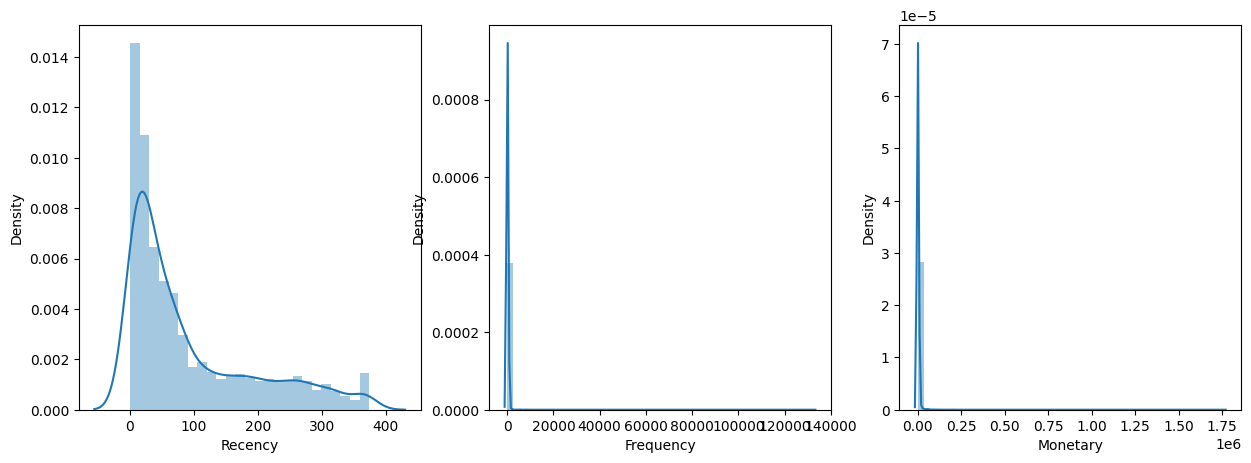

In [106]:
# plot distribution of recency, frequency and monetary
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.distplot(rfm["Recency"], ax=ax[0])
sns.distplot(rfm["Frequency"], ax=ax[1])
sns.distplot(rfm["Monetary"], ax=ax[2])
plt.show()

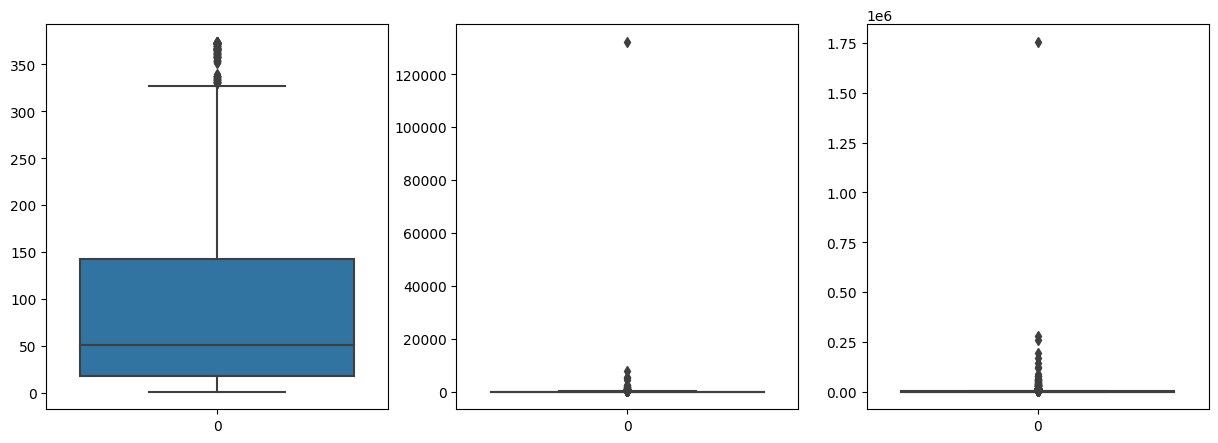

In [107]:
# plot distribution of recency, frequency and monetary
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(rfm["Recency"], ax=ax[0])
sns.boxplot(rfm["Frequency"], ax=ax[1])
sns.boxplot(rfm["Monetary"], ax=ax[2])
plt.show()


In [108]:
# calculate quartiles for recency, frequency and monetary
quantiles = rfm[["Recency", "Frequency", "Monetary"]].quantile(q=[0.20, 0.40, 0.60, 0.80])
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.2: 13.0, 0.4: 33.0, 0.6: 72.0, 0.8: 179.0},
 'Frequency': {0.2: 14.0, 0.4: 29.0, 0.6: 58.0, 0.8: 121.0},
 'Monetary': {0.2: 250.216,
  0.4: 490.28000000000003,
  0.6: 942.324,
  0.8: 2060.4940000000006}}

In [109]:
# create a function to calculate RFM score
def RScore(x, p, d):
    if x <= d[p][0.20]:
        return 5
    elif x <= d[p][0.40]:
        return 4
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.80]:
        return 2
    else:
        return 1

def FMScore(x, p, d):
    if x <= d[p][0.20]:
        return 1
    elif x <= d[p][0.40]:
        return 2
    elif x <= d[p][0.60]:
        return 3
    elif x <= d[p][0.80]:
        return 4
    else:
        return 5

# create RFM segments
rfm["R"] = rfm["Recency"].apply(RScore, args=("Recency", quantiles))
rfm["F"] = rfm["Frequency"].apply(FMScore, args=("Frequency", quantiles))
rfm["M"] = rfm["Monetary"].apply(FMScore, args=("Monetary", quantiles))
rfm.head()

,CustomerID,LastPurchaseDate,Recency,Frequency,Monetary,R,F,M
0,0,2011-12-09 10:26:00,1,132220,1755276.64,5,5,5
1,12346,2011-01-18 10:01:00,326,1,77183.60,1,1,5
2,12347,2011-12-07 15:52:00,2,182,4310.00,5,5,5
3,12348,2011-09-25 13:13:00,75,31,1797.24,2,3,4
4,12349,2011-11-21 09:51:00,19,73,1757.55,4,4,4


In [110]:
# create RFM score
rfm["RFMScore"] = rfm.R.map(str) + rfm.F.map(str) + rfm.M.map(str)
rfm.head()

,CustomerID,LastPurchaseDate,Recency,Frequency,Monetary,R,F,M,RFMScore
0,0,2011-12-09 10:26:00,1,132220,1755276.64,5,5,5,555
1,12346,2011-01-18 10:01:00,326,1,77183.60,1,1,5,115
2,12347,2011-12-07 15:52:00,2,182,4310.00,5,5,5,555
3,12348,2011-09-25 13:13:00,75,31,1797.24,2,3,4,234
4,12349,2011-11-21 09:51:00,19,73,1757.55,4,4,4,444


In [112]:
rfm.groupby("RFMScore").agg({
    "Recency": ["mean", "min", "max", "count"], 
    "Frequency": ["mean", "min", "max", "count"], 
    "Monetary": ["mean", "min", "max", "count"]
    }).round(1).head()

Recency                 Frequency               Monetary          \
            mean  min  max count      mean min max count     mean     min   
RFMScore                                                                    
111        278.8  180  374   272       7.0   1  14   272    139.0     3.8   
112        278.4  184  374    74       9.2   1  14    74    328.8   251.2   
113        262.9  184  366    21       5.9   1  13    21    692.9   516.4   
114        266.6  195  372    11       8.6   2  14    11   1450.2   944.1   
115        244.2  182  326     5       3.8   1  10     5  33708.5  3096.0   

                         
              max count  
RFMScore                 
111         250.0   272  
112         489.6    74  
113         931.5    21  
114        2002.4    11  
115       77183.6     5